# 手写数字识别

## 导入包

In [1]:
import numpy as np
import os
import copy
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 数据准备

导入数据，并且构成DataLoader的数据格式，首先导入数据，由于手写数字识别的数据集在datasets包里，可以直接下载使用。

下载并且完成一些基本的数据格式转换。

In [2]:
mnist_data = datasets.MNIST('data/', train=True, download=True, 
                            transform=transforms.Compose([
                                transforms.ToTensor()      # 把图片转换成张量
                            ])
                           )
mnist_data   # 这是一个Dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

下载完毕后，查看图片形状

In [3]:
# minist_data[i]表示第几张图片，[i][0]表示图片的张量，[i][1]表示类别
mnist_data[10][0].shape
# 第一个维度是通道数，第二个是图片的长，第二个维度是图片的宽

torch.Size([1, 28, 28])

In [4]:
# 下面求一下数据的均值和方差
# 为了后面的数据标准化，更容易进行模型的训练
data = [d[0].data.cpu().numpy() for d in mnist_data]
np.mean(data), np.std(data)

(0.13066062, 0.30810776)

有了Dataset，就可以构建DataLoader

In [5]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=True, download=True, 
                   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.13066062,), (0.30810776,))   # 把所有数据进行归一化之后， 可以使得训练速度加快
                   ])), batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True   # 这个也是为了加速训练
)
test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=False, download=True, 
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.13066062,), (0.30810776,))
                  ])), batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
)

## 模型的构建与训练

搭建模型（类似于LeNet结构）：卷积->池化->卷积->池化->两个全连接层

卷积神经网络的搭建，有个比较重要的点就是每一步要弄清数据的维度变化。
- 首先有一批图片，维度是[batch_size, 1, 28, 28]，PyTorch中，图片通道数位于第二维
- 经过卷积层，卷积核个数20，大小5\*5，数据维度[batch_size, 20, 24, 24]
  - 这个20是卷积核个数，也是输出数据的通道数
  - 长宽变化：(原尺寸-卷积核大小)/步长+1=(28-5)/1+1=24
- 经过池化层，核大小2\*2，图片长宽变为输入的一半，数据维度[batch_size, 20, 12, 12]
- 经过卷积层，卷积核个数50，大小5\*5，数据维度[batch, 50, 8, 8]
- 经过池化层，核大小2\*2，图片长宽变为输入的一半，数据维度[batch_size, 20, 4, 4]
- 改变形状，数据维度[batch_size, 4\*4\*50]
- 接两个全连接层，数据维度[batch_size, 10]

最后变成一个10分类问题、

Conv2d参数：
- torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode=‘zeros’)

MaxPool2d参数：
- torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)   #  24*24   输出维度是20
        self.conv2 = nn.Conv2d(20, 50, 5, 1)   # 20*20   输出维度是50
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # X: 1*28*28
        x = F.relu(self.conv1(x))     #  [batch_size,20, 24, 24]   第二维是out_channels
        x = F.max_pool2d(x, 2, 2)    # [batch_size, 20, 12, 12]
        x = F.relu(self.conv2(x))    # [batch_size, 50, 8, 8]
        x = F.max_pool2d(x, 2, 2)   # [batch_size, 50, 4, 4]
        x = x.view(-1, 4*4*50)      # [batch_size, 1, 4*4*50]
        x = F.relu(self.fc1(x))      # [batch_size, 500]
        x = self.fc2(x)  # [batch_size, 10]
        
        return F.log_softmax(x, dim=1)     # 在第一个维度上进行分类

网络构建完成后，定义函数进行训练

依然是训练代码与测试代码分开写，这样训练的时候比较清晰

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        pred = model(data)     # batch_size*10
        loss = F.nll_loss(pred, target)
        
        # SGD 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 100 == 0:
            print('Train Epoch: {}, iteration: {}, Loss: {}'.format(epoch, idx, loss.item()))

def test(model, device, test_loader):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            total_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    total_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset) * 100.
    print('Test loss: {}, Accuracy:{}'.format(total_loss, acc))

这里损失函数采用NLLLoss（就是softmax取负号），希望softmax之后，正确标签的概率越大越好，然后取负号就是希望正确标签的值越小越好，就对应NLLLoss

开始模型训练

In [8]:
lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(num_epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

Train Epoch: 0, iteration: 0, Loss: 2.318403959274292
Train Epoch: 0, iteration: 100, Loss: 0.5317106246948242
Train Epoch: 0, iteration: 200, Loss: 0.49998578429222107
Train Epoch: 0, iteration: 300, Loss: 0.21852730214595795
Train Epoch: 0, iteration: 400, Loss: 0.12791477143764496
Train Epoch: 0, iteration: 500, Loss: 0.38944199681282043
Train Epoch: 0, iteration: 600, Loss: 0.14336960017681122
Train Epoch: 0, iteration: 700, Loss: 0.1180097684264183
Train Epoch: 0, iteration: 800, Loss: 0.3231854736804962
Train Epoch: 0, iteration: 900, Loss: 0.029980473220348358
Train Epoch: 0, iteration: 1000, Loss: 0.1075289249420166
Train Epoch: 0, iteration: 1100, Loss: 0.05399481952190399
Train Epoch: 0, iteration: 1200, Loss: 0.09147675335407257
Train Epoch: 0, iteration: 1300, Loss: 0.17822223901748657
Train Epoch: 0, iteration: 1400, Loss: 0.12545539438724518
Train Epoch: 0, iteration: 1500, Loss: 0.19752934575080872
Train Epoch: 0, iteration: 1600, Loss: 0.05556933954358101
Train Epoch: 0

# CNN模型的迁移学习

常用以下两种方式做迁移学习：
- fine tuning：从一个预训练开始，改变一些模型的架构，然后继续调整模整个模型的参数。
- feature extraction：不再改变预训练模型的参数，只更新改变过的部分模型参数。
  - 之所以称之为feature extraction是因为把预训练的CNN模型当作一个特征提取模型，利用提取出来的特征完成训练任务。
  
构建迁移学习的步骤：
1. 初始化预训练模型
2. 把最后一层的输出层改变成想要分的类别数
3. 定义一个optimizer更新参数
4. 模型训练

迁移学习采用的是hymenoptera_data数据集，使用datasets.ImageFolder读取数据。

之后用data.DataLoader转成DataLoader，但是在数据读取之前，先做一些参数定义：
- 数据路径
- 预训练模型的名称
- 分类个数
- batch_size
- 迁移学习的方式
- 输入图片的形状

## 初始化预训练模型

In [9]:
# to the ImageFolder structure
data_dir = "data/hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
# when True we only update the reshaped layer params
feature_extract = True
input_size = 224

## 读取数据

做一些预处理，同时分成训练集和验证集

In [10]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
        batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

## 模型初始化操作

模型选用resnet模型，同时想用这个网络作特征提取器，那么就需要冻结网络的前面层（即将所有的param.requires_grad=False），不让这些层进行训练，而改了后面的全连接层，把输出分成2分类。

In [11]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == 'resnet':
        # use_pretrained为True，拿到是torchvision训练好的模型，否则是随机初始化参数
        model_ft = models.resnet18(pretrained=use_pretrained)
        # 如果选择后面的这种特征提取模式，会冻结前面的所有参数
        set_parameter_requires_grad(model_ft, feature_extract)
        # 拿到resnet18最后的一个fc的in_features, 把之前的1000分类改成2分类
        num_ftrs = model_ft.fc.in_features
        # 把最后的一个fc改了
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print('model not implemented')
        return None, None
    
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, 
                                        feature_extract, use_pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# 只需要改全连接层的参数，前面的不动
print(model_ft.layer1[0].conv1.weight.requires_grad)
print(model_ft.fc.weight.requires_grad)

False
True


同时需要微调前面的参数，此时经常会用到两组学习率进行微调：
- 前面的层数用较小的学习率
- 后面的层数用较大的学习率

## 模型训练

In [13]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            running_loss = 0.
            running_corrects = 0.
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)    # bsize * 2
                    loss = loss_fn(outputs, labels)
                preds = outputs.argmax(dim=1)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print('Phase {} loss: {}, acc: {}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [14]:
model_ft = model_ft.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.9)   # 这里是筛选出需要更新的参数进行更新
loss_fn = nn.CrossEntropyLoss()

_, ohist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.682989239692688, acc: 0.5819672131147541
Phase val loss: 0.5739691514594882, acc: 0.7254901960784313
Phase train loss: 0.5177661625088238, acc: 0.7991803278688525
Phase val loss: 0.41445744018149533, acc: 0.8431372549019608
Phase train loss: 0.39893033172263476, acc: 0.8647540983606558
Phase val loss: 0.32545705363641375, acc: 0.9150326797385621
Phase train loss: 0.3505223857574776, acc: 0.8565573770491803
Phase val loss: 0.2750035684093151, acc: 0.934640522875817
Phase train loss: 0.30311426935625857, acc: 0.8811475409836066
Phase val loss: 0.24724241623691484, acc: 0.9281045751633987
Phase train loss: 0.2744458361727292, acc: 0.9180327868852459
Phase val loss: 0.2307880542247124, acc: 0.934640522875817
Phase train loss: 0.2977292711128954, acc: 0.8729508196721312
Phase val loss: 0.22461512899087147, acc: 0.934640522875817
Phase train loss: 0.25576169080421574, acc: 0.889344262295082
Phase val loss: 0.22232871040020113, acc: 0.9281045751633987
Phase train loss: 0.2

## 绘制损失函数

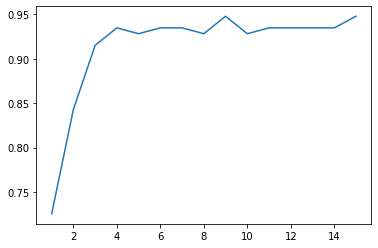

In [15]:
plt.plot(range(1,num_epochs+1),ohist)